### Author : Si Dan HO

# Statistique des risques extrêmes

In [291]:
import pandas as pd
import numpy as np
import scipy.stats as sps
from scipy.stats import skew, kurtosis, kurtosistest
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import os
import statsmodels.api as sm 
import pylab as py
from tabulate import tabulate
import seaborn

NB : l'ensemble des Value at Risk calculés sont en réalité les pertes en terme de rendements de l'indice du CAC40. Pour calculer la vrai Value at Risk, il convient de multiplier les quantités calculés dans le projet par la valeur actuelle de l'indice du CAC40.

## Sommaire 

- Value at Risk : Fondement et modélisation
    - Traitements préliminaires et visualisation
    - Value at Risk Historique
    - Value at Risk Glissante
    - VaR Paramétriques
        - Implémentation de la fonction d'estimation par maximum de vraisemblance
        - VaR Gaussienne
        - VaR Skew Gaussienne
        - VaR Skew Student
        - Validation ex post
- Value at Risk par modélisation des extrêmes
    - Modélisation par maxima par blocs
        - Construction de l'échantillon des maximas et estimation de la loi adaptée
        - Estimation des paramètres de la distribution GEV
        - Test de l'adéquation de la distribution estimée sur les données maxima
        - Estimation de la VaR par la méthode des Blocs Maximas (BM)
        - Validation ex post
    - Modélisation : Méthode Peak Over Threshold
        - Capture des rendements en excès par rapport au seuil u
        - Détermination du seuil optimal u
        - Estimation du maximum de vraisemblance puis par la méthode des moments
        - Validation ex ante
        - Test statistique d'adéquation
        - Redressement du niveau de quantile
        - Calcul de la VaR à partir de la méthode Peak Over Threshold
        - Validation Ex Post
- Calcul de la VaR dynamique
    - Etude de la série temporelle
        - Statistiques descriptives
        - Etude de la stationarité et de la présence d'autocorrelation dans la série
        - Modélisation d'un AR(1) sur la série
        - Détection d'effet ARCH sur les résidus du modèle AR
        - Modélisation d'un GARCH(1,1) sur les résidus du modèle AR
            - Diagnostic du modèle
        - Calcul de la VaR dynamique sur les résidus du modèle AR-GARCH
        - Backtesting de la VaR dynamique

## Value at Risk : Fondements et modélisation

### Traitements préliminaires et visualisation

#### Import et visualisation de l'indice CAC40

In [532]:
abs_path = "C:\\Users\Si Dan\Documents\Statistiques de risques extrêmes"
file_path = os.path.join(abs_path, "CAC40.csv")

In [533]:
pd_df = pd.read_csv(file_path, engine = 'python', index_col='Date')

In [534]:
pd_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-07,6027.540039,6044.970215,5999.950195,6029.750000,6029.750000,82348500.0
2020-02-10,6008.479980,6018.310059,5993.910156,6015.669922,6015.669922,65703100.0
2020-02-11,6047.959961,6060.970215,6032.790039,6054.759766,6054.759766,81568400.0
2020-02-12,6064.250000,6104.729980,6062.970215,6104.729980,6104.729980,92681200.0
2020-02-13,6076.919922,6098.259766,6028.279785,6093.140137,6093.140137,92665700.0


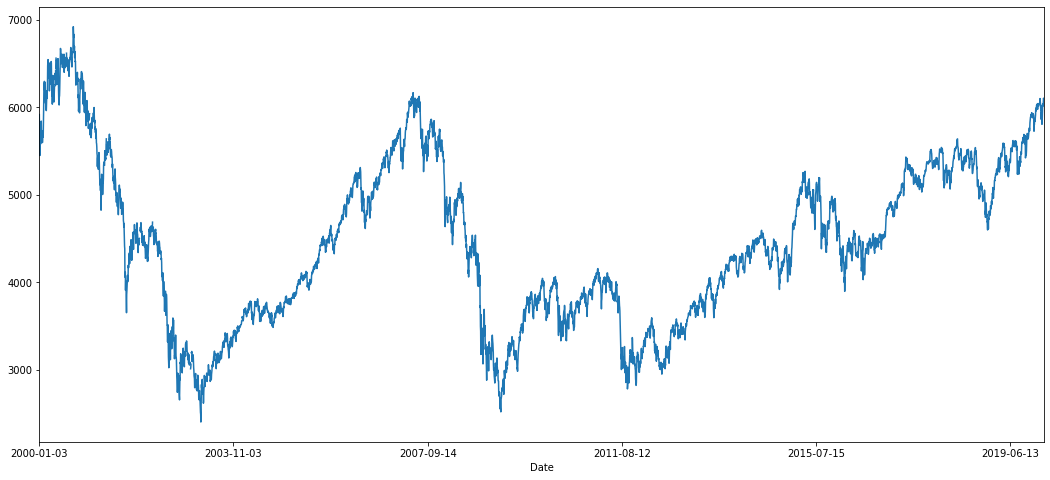

In [535]:
pd_df["Close"].plot(figsize = (18,8))

In [536]:
# Stat desc variables quanti
pd_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5139.000000,5139.000000,5139.000000,5139.000000,5139.000000,5.139000e+03
mean,4448.976133,4479.936044,4414.215031,4447.706891,4447.706891,9.251231e+07
std,928.603490,929.731481,927.512416,928.559125,928.559125,6.714357e+07
min,2453.050049,2518.290039,2401.149902,2403.040039,2403.040039,0.000000e+00
25%,3708.719971,3732.639892,3682.780029,3708.140014,3708.140014,4.721810e+07
50%,4402.790039,4431.700195,4369.209961,4400.750000,4400.750000,9.712460e+07
75%,5200.160156,5226.899902,5160.569824,5195.835205,5195.835205,1.328184e+08
max,6929.049805,6944.770020,6838.700195,6922.330078,6922.330078,5.312476e+08


#### Traitement des valeurs manquantes

In [537]:
# Comptage des valeurs manquantes
len(pd_df.loc[pd_df["Close"].isna()])

35

In [538]:
# Imputation des valeurs NA
pd_df = pd_df.fillna(method ='ffill')
len(pd_df.loc[pd_df["Close"].isna()])

0

#### Calcul des rendements et rendements logarithmiques

In [539]:
pd_df["Return"] = pd_df["Close"].diff()/pd_df["Close"]
pd_df["Log_Returns"] = np.log(1+pd_df["Close"].diff()/pd_df["Close"])

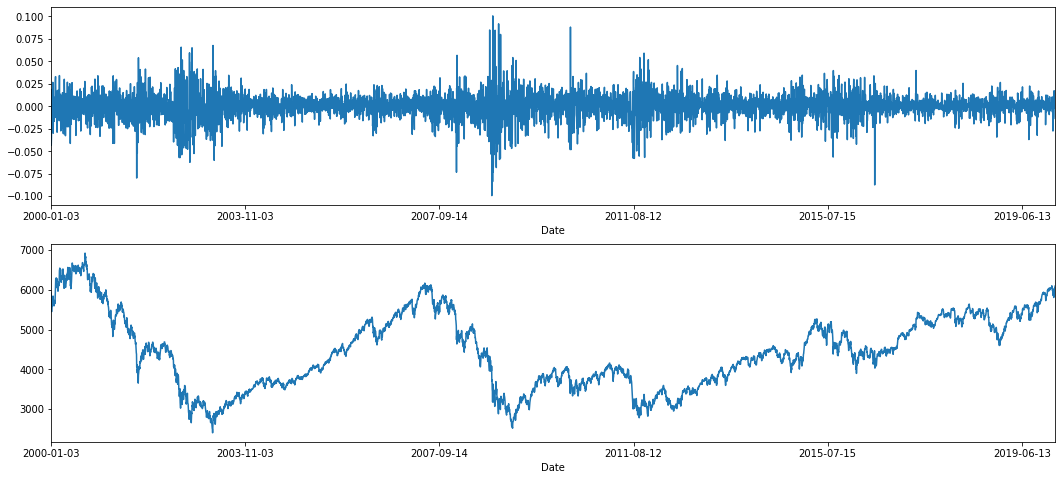

In [540]:
fig, ax = plt.subplots(2,1)
plt1 = pd_df["Return"].plot(ax=ax[0], figsize = (18,8))
plt2 = pd_df["Close"].plot(ax=ax[1], figsize = (18,8), y='Value')

#### Division échantillons apprentissage et test

In [546]:
n = len(pd_df)
split = int(n*0.8)
pd_df.drop('2000-01-03', inplace=True)
train, test = pd_df.iloc[0:split], pd_df.iloc[split:]
Returns_train = train["Return"]
Log_Returns_train = train["Log_Returns"]

Returns_test = test["Return"]
Log_Returns_test = test["Log_Returns"]

In [547]:
print(Returns_train)

Date
2000-01-04   -0.043256
2000-01-05   -0.035097
2000-01-06   -0.005429
2000-01-07    0.016156
2000-01-10    0.018864
                ...   
2016-01-25   -0.005882
2016-01-26    0.010439
2016-01-27    0.005376
2016-01-28   -0.013465
2016-01-29    0.021476
Name: Return, Length: 4139, dtype: float64


#### Distribution du log rendement

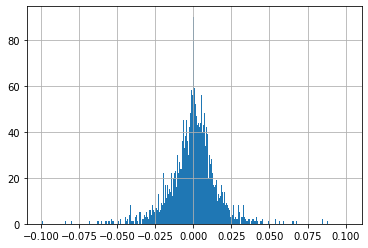

In [548]:
dist = train["Return"].hist(bins=600, grid = "False")

## Calcul des VaR

### VaR Historique

La VaR Historique de niveau de confiance $\alpha$ consiste simplement à calculer le quantile empirique d'ordre $1-\alpha$ des rendements historiques.

In [656]:
# On trie les valeurs du log return
train.sort_values('Return', inplace=True, ascending = True)

# Calcul des quantiles
VaR_90 = train["Return"].quantile(0.1)
VaR_95 = train["Return"].quantile(0.05)
VaR_99 = train["Return"].quantile(0.01)

# Print des valeurs
print(tabulate([['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]], headers = ['Confidence Level','Value at Risk']))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0169826
95%                      -0.0246215
99%                      -0.0435704


C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Validation Ex Post

Une des pratiques communes consiste à valider postérieurement le calcul de la VaR en le testant sur un échantillon indépendant. Cela est appelé le Backtesting. Dans la pratique commune, le test est effectué sur des données du passés. Dans notre cas, la VaR calculée sur l'échantillon d'apprentissage sera testé sur l'échantillon de validation pour évaluer sa pertinence. Il s'agira de calculer le nombre d'exception c'est à dire le nombre d'observations de rendements qui sont en dessous de VaR (ou pertes dépassant la VaR), et évaluer si leur proportion dépasse le niveau de la VaR.

Plus précisément, on déclare les variables de dépassements en $t+1$ de la VaR calculée en $t$ qui sont $I_t = \mathbb{1}_{r_{t+1} < VaR_{h,t+1}(\alpha)} \sim \mathcal{B}(1-\alpha)$. 

Ces variables étant i.i.d par hypothèse sur les rendements journaliers, le nombre total des exceptions est donc défini par :

$$
\sum_{t=1}^n I_t \sim \mathcal{B}(n,1-\alpha)
$$.

Le but est donc de tester l'adéquation entre la distribution empirique du nombre total de dépassements $\sum_{t=1}^n I_t$ issues de l'échantillon test, et la distribution théorique qui est la loi Binomiale $\mathcal{B}(n,1-\alpha)$. La proportion d'exceptions $p$ doit donc être égale à $1- \alpha$. Le test à effectuer doit accepter l'hypothèse $H_0$ qui est $p = 1- \alpha$. Pour cela, la fonction binom_test peut effectuer ce test avec cette hypothèse selon le nombre d'exceptions.

Dans la règlementation, le niveau de VaR doit être égal à $\alpha = 99%$. Cette quantité sera donc prise en référence.

Pour cela, le calcul du nombre d'exceptions est implémenté comme suit :

In [432]:
# Construction de l'échantillon des exceptions
def Backtesting(data, VaR):
    n = len(data)
    exception_nb = 0 
    for i in range(n):
        if data[i] < VaR:
            exception_nb +=1
    return exception_nb

Cela permet ainsi d'effectuer le test pour vérifier que la proportion d'exception soit égale à $1-\alpha$:

In [446]:
# Application de la fonction pour la VaR Historique
backesting_histo = Backtesting(Returns_test, VaR_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_histo = backesting_histo/n
print("La proportion d'exceptions est égale à %.3f" % prop_histo)
      
# Test d'adéquation 
p = sps.binom_test(x = backesting_histo,n=n , p=0.01)
print('p-value=%.3f' % p)
# Interprétation
alpha = 0.05
if p > alpha:
    print("Le nombre d'exceptions au regard de la VaR Histo suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR Histo ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.001
p-value=0.001
Le nombre d'exceptions au regard de la VaR Histo ne suit pas une Binomiale avec p = 1%


Ainsi, la VaR historique ne peut être validé au vue des résultats du backtesting donc le nombre d'exceptions de l'échantillon test ne suit bien une loi Binomiale de paramètre $n$ qui est la taille de l'échantillon test et $p=1%$. Cela nous contraint ainsi à trouver d'autres types de VaR.

Plus précisément, il est possible de remarquer que la proportion d'exceptions est largement inférieure à 1%, montrant ainsi que la VaR calculée est très conservatrice.

### VaR Glissante

La VaR Glissant consiste à calculer la VaR historique uniquement sur une proportion de l'échantillon initiale, qui est de taille $window$, représentant la fenêtre arbitrairement choisi auquel la VaR serait calculé, et cette opération est réitérée pour chaque temps. Ainsi, cela permet ainsi d'obtenir à partir du temps $window+1$ d'obtenir pour chaque observation une VaR historique. Il s'agit en quelque sorte d'une méthode de VaR dynamique historique.

In [552]:
n=len(pd_df)
VaR_histo_glissante = []
window = 251
for i in range(n-window):
    x = pd_df["Return"].iloc[i:i+window+1]
    VaR_histo_glissante.append(np.quantile(a=x, q=0.01, interpolation = 'linear'))

Text(0.5, 1.0, 'VaR Glissante des rendements du CAC40')

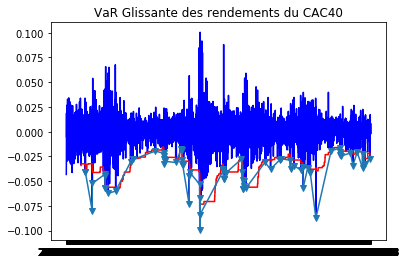

In [662]:
fig, ax = plt.subplots(1,1)

ax.plot(pd_df.index, pd_df.Return, 'b-')
ax.plot(pd_df.index[window:], VaR_histo_glissante, 'r-')
ax.plot(pd_df.iloc[window:][VaR_histo_glissante > pd_df.Return.iloc[window:]].index, pd_df.Return.iloc[window:][VaR_histo_glissante > pd_df.Return.iloc[window:]], marker = 'v')
ax.set_title("VaR Glissante des rendements du CAC40")

## VaR Paramétriques

### Implémentation de la fonction d'estimation par maximum de vraisemblance

Les VaR Paramétriques reposent sur le fait que l'on suppose que le P&L ou le rendement suivent une certaine loi, de paramètres qui sont ainsi estimés, et c'est à partir de ce postulat que les VaR sont estimées en conséquences.

L'estimation des paramètres définissant la distribution du rendement est celle du maximum de Vraisemblance. C'est pourquoi il convient d'implémenter la fonction qui minimise l'opposé de la log-vraisemblance.

In [86]:
# implémentation de la log-vraisemblance
# function est un paramètre représentant la densité d'une certaine loi
def log_likelihood(data_matrix, function, param):
    fun = lambda x : function(x, *param)
    log_likelihood = np.sum(np.log(fun(data_matrix)))
    return log_likelihood

In [244]:
# implémentation de l'estimateur par maximum de vraisemblance
def max_log_likelihood(data_matrix, function, nb_param):
    x0 = np.random.rand(nb_param)
    fun_opti = lambda param : -log_likelihood(data_matrix, function, param)
    param_opti = sp.optimize.minimize(fun_opti,x0, method='Nelder-Mead')
    return param_opti.x

### VaR Gaussienne

Rappelons le principe de la Value at Risk Gaussienne :

Nous supposons que les rendements suivent une loi normale $N(\mu, \sigma^2)$.

De ce fait, sachant que la VaR de niveau de confiance $\alpha$ est son quantile d'ordre $\alpha$, il est clair que :
$VaR_{\alpha}(R) = \mu + \sigma* \Phi^{-1}(1-\alpha)$, avec $\Phi$ la fonction de répartition d'une variable gaussienne centrée réduite.

Rappelons que :
- $\Phi^{-1}(0.1)=-1.282$
- $\Phi^{-1}(0.05)=-1.645$
- $\Phi^{-1}(0.01)=-2.326$

Pour calculer la VaR Gaussienne selon les différents niveaux de confiances, il est nécessaire d'estimer les paramètres de la distribution Gaussienne, en supposant que les rendements suivent une loi normale. Pour cela, nous effectuons une estimation par maximum de vraisemblance.

In [448]:
# Estimation par maximum de vraisemblance des paramètres de la loi normale
param_normal = max_log_likelihood(Returns_train, sps.norm.pdf,2)
print(param_normal)

[-0.00018665  0.01497274]


Afin de vérifier l'exactitude des paramètres estimées, nous effectuons une estimation en utilisant la fonction "norm.fit" du package scipy.stat permettant de fitter une distribution gaussienne sur les données et d'en estimer les paramètres.

In [449]:
# Fittage de la distribution Gaussienne
mu, sigma = sps.norm.fit(Returns_train)
print(mu, sigma)

-0.00018790821993925233 0.014972058197696418


Nous pouvons ainsi constater que les paramètres estimés sont très similaires, ce qui permet de valider leur exactitude. A partir de ces quantités, il est ainsi posible de calculer les VaR Gaussiennes suivantes:

In [450]:
# Calcul de la moyenne et de l'écart type du Log Return
mu = np.mean(train["Return"])
sigma = np.std(train["Return"])

# Calcul des quantiles
VaR_G_90 = mu - 1.282*sigma
VaR_G_95 = mu - 1.645*sigma
VaR_G_99 = mu - 2.326*sigma

# Print des valeurs
print(tabulate([['90%', VaR_G_90], ['95%', VaR_G_95], ['99%', VaR_G_99]], headers = ['Confidence Level','Gaussian Value at Risk']))

Confidence Level      Gaussian Value at Risk
------------------  ------------------------
90%                               -0.0193821
95%                               -0.0248169
99%                               -0.0350129


Pour être davantage précis, la VaR peut être calculée directement en la considérant comme le quantile d'ordre $1-\alpha$ des rendements supposés suivre une loi $N(\mu, \sigma^2)$ qui doit être calculé par la fonction ppf fournie par le package scipy.stats.

In [451]:
# Calcul des VaR Gaussiennes
VaR_G_90 = sps.norm.ppf(0.1, mu, sigma) # ppf = percentage point function
VaR_G_95 = sps.norm.ppf(0.05, mu, sigma)
VaR_G_99 = sps.norm.ppf(0.01, mu, sigma)

# Print des valeurs
print(tabulate([['90%', VaR_G_90], ['95%', VaR_G_95], ['99%', VaR_G_99]], headers = ['Confidence Level','Gaussian Value at Risk']))

Confidence Level      Gaussian Value at Risk
------------------  ------------------------
90%                               -0.0193754
95%                               -0.0248148
99%                               -0.0350181


#### Validation Ex Post

Une fois de plus, la VaR Gaussienne doit faire l'objet d'un backtesting pour sa validation, le nombre d'exceptions de l'échantillon test est calculé et sa distribution doit suivre une loi Binomiale $B(n,1-\alpha)$ avec $\alpha = 0.99$. De ce fait :

In [452]:
# Application de la fonction pour la VaR Gaussienne
backesting_Gaussienne = Backtesting(Returns_test, VaR_G_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_Gaussienne = backesting_Gaussienne/n
print("La proportion d'exceptions est égale à %.3f" % prop_Gaussienne)

# Test d'adéquation
p = sps.binom_test(x = backesting_Gaussienne, n=n, p=0.01)
print('p-value=%.3f' % p)
# Interprétation 
if p > 0.05:
    print("Le nombre d'exceptions au regard de la VaR Gaussienne suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR Gaussienne ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.003
p-value=0.017
Le nombre d'exceptions au regard de la VaR Gaussienne ne suit pas une Binomiale avec p = 1%


Malheureusement, la VaR Gaussienne ne peut être validée. Par ailleurs, cette distribution présente de nombreuses limites qui seront détaillées dans les paragraphes suivants.

Nous pouvons constater que la proportion d'exceptions, égale à $0.3\%$, est largement inférieure à $1\%$, montrant ainsi que la VaR Gaussienne est fortement conservatrice.

### Var Skew Gaussienne

Cependant, l'hypothèse Gaussien des rendements peut être questionnée. Cela passe en premier lieu par la potentielle présence d'asymétrie dans la distribution. Pour cela, cette asymétrie est calculée puis sa significativité sera testée afin d'évaluer sa pertinence.

In [24]:
# Calcul de l'asymétrie
Returns_train.skew()

-0.28512868296639526

In [25]:
sps.skewtest(Returns_train)

SkewtestResult(statistic=-7.3549389274967645, pvalue=1.9101443074280504e-13)

Nous pouvons ainsi constater que les rendements possèdent une asymétrie négative qui est significative. Ainsi, en maintenant l'hypothèse de rendements gaussien, la présence d'asymétrie est prise en compte en calculant cette fois ci la VaR Gaussienne Asymétrique.

Pour cela, nous estimons les paramètres de la distribution Gaussienne Asymétrique par maximum de vraisemblance, conformément aux données à notre disposition :

In [327]:
# Estimation des paramètres de la Skew Gaussienne par maximum de vraisemblance
param_skew_normal = max_log_likelihood(Returns_train, sps.skewnorm.pdf,3)
print(param_skew_normal)

 final_simplex: (array([[ 0.45826127, -0.00546034,  0.01587329],
       [ 0.45820264, -0.00545957,  0.01587299],
       [ 0.45833092, -0.00546089,  0.01587349],
       [ 0.45817471, -0.00545923,  0.01587297]]), array([-11514.66907513, -11514.66907507, -11514.66907504, -11514.66907494]))
           fun: -11514.669075127616
       message: 'Optimization terminated successfully.'
          nfev: 219
           nit: 123
        status: 0
       success: True
             x: array([ 0.45826127, -0.00546034,  0.01587329])


C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Afin de vérifier l'exactitude des paramètres estimées, nous effectuons une estimation en utilisant la fonction "skewnorm.fit" du package scipy.stat permettant de fitter une distribution skew gaussienne sur les données et d'en estimer les paramètres.

In [417]:
# Fittage de la distribution Gaussienne
skew, mu, sigma = sps.skewnorm.fit(Returns_train)
print(skew, mu, sigma)

0.45825007295788645 -0.0054600831762929266 0.015873281849766215


Nous pouvons ainsi constater que les paramètres estimés sont très similaires, ce qui permet de valider leur exactitude. A partir de ces quantités, il est ainsi posible de calculer les VaR Skew Gaussiennes suivantes:

In [418]:
# Calcul des VaR Gaussiennes asymétriques
VaR_SG_90 = sps.skewnorm.ppf(0.1, skew, mu, sigma) # ppf = percentage point function
VaR_SG_95 = sps.skewnorm.ppf(0.05, skew, mu, sigma)
VaR_SG_99 = sps.skewnorm.ppf(0.01, skew, mu, sigma)

# Print des valeurs
print(tabulate([['90%', VaR_SG_90], ['95%', VaR_SG_95], ['99%', VaR_SG_99]], headers = ['Confidence Level','Skew Gaussian Value at Risk']))

Confidence Level      Skew Gaussian Value at Risk
------------------  -----------------------------
90%                                    -0.019335
95%                                    -0.0247272
99%                                    -0.0348182


#### Validation Ex Post

On effectue de même un backtesting pour la VaR Skew Gaussienne :

In [453]:
# Application de la fonction pour la VaR Skew Gaussienne
backesting_SGaussienne = Backtesting(Returns_test, VaR_SG_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_SGaussienne = backesting_SGaussienne/n
print("La proportion d'exceptions est égale à %.3f" % prop_SGaussienne)

# Test de la loi binomiale
p_value = sps.binom_test(x = backesting_SGaussienne, n = n, p=0.01)
print('p-value=%.3f' % p_value)
# Interprétation
alpha = 0.05
if p > alpha:
    print("Le nombre d'exceptions au regard de la VaR Skew Gaussienne suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR Skew Gaussienne ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.003
p-value=0.017
Le nombre d'exceptions au regard de la VaR Skew Gaussienne ne suit pas une Binomiale avec p = 1%


La VaR Skew Gaussienne n'est pas non plus validée. La proportion d'exception reste la même que celle calculée avec la VaR Gaussienne précédente. La distribution des rendements ne suivent en général pas une loi Gaussienne, d'où la non validation de cette VaR. Cela sera démontré dans le paragraphe suivant.

### Var Skew Student 

Cependant, la présence d'asymétrie permet par ailleurs de s'intérroger sur le caractère gaussien de la distribution des rendements. Il est connu que la distribution du P&L (ou du rendement logarithmique dans notre cas) est à queue lourde, qu'il convient de tester présentement. Par ailleurs, le caractère gaussien doit être testé via le diagramme quantile-quantile ainsi qu'un test Quantile-Quantile. En général, cette distribution est de plus asymétrique, avec un skew négatif. Cela conduit ainsi à considérer une distribution de Student plutôt que Gaussienne pour les rendements.

In [27]:
Returns_train.kurtosis()

4.452056720505794

In [28]:
stat, p = sps.kurtosistest(Returns_train)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print('The Kurtosis is not significantly different from the Gaussian One (fail to reject H0)')
else:
    print('The Kurtosis is significantly different from the Gaussian One (reject H0)')

Statistics=20.489, p=0.000
The Kurtosis is significantly different from the Gaussian One (reject H0)


Nous pouvons ainsi constater que les rendements sont à queue épaisses au vu du kurtosis qui est fortement significatif, et supérieur à celui d'une distribution gaussienne normale, qui est égale à 3. Cela est confirmé par le test du Kurtosis au vu de sa p-valeur.

Par la suite, la normalité des rendements est vérifiée via le traçage du diagrame Quantile-Quantile ainsi que du test de Normalité.

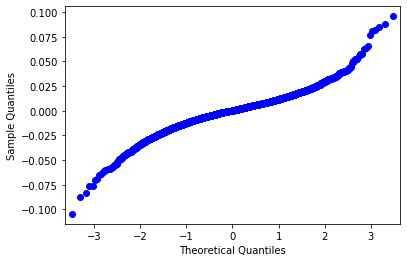

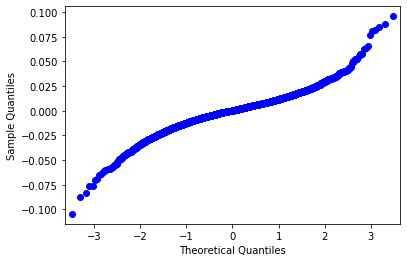

In [29]:
sm.qqplot(Returns_train)

In [ ]:
from scipy.stats import shapiro
# Test de Normalité
stat, p = shapiro(Returns_train)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Comme attendu, l'hypothèse nulle de distribution Gaussienne est donc rejetée au vue de la p-valeur, confirmant ainsi qu'il n'est pas valable de considérer l'hypothèse de rendements Gaussiens. Cela est appuyé visuellement par la courbe Quantile-Quantile tracée ci dessus.

Il est donc décidé de considérer que les Rendements suivent une loi de Student asymétrique, et la VaR doit donc être calculé en prenant en compte ce cas de figure. Cette VaR est appelée Skew Student VaR. Rappelons que la VaR de niveau de confiance $\alpha$ est le quantile d'ordre $1-\alpha$ des Rendements.

Pour commencer, la densité de la loi de Skew Student est construite :

In [252]:
# on défini la densité de la loi Skew Student
def f_skewstud(x, *params):
    # Chargement des paramètres
    mu, sigma, gamma, nu = params
    
    # Définition des composantes de calcul
    y = ((gamma*(x- mu))/sigma)*(np.sqrt((nu+1)/(((x- mu)/sigma)**2)+ nu))
    f_t = lambda x : sps.t.pdf(x, df = nu, loc = mu, scale = sigma)
    F_t = lambda x : sps.t.cdf(y, df = nu+1, loc = mu, scale = sigma)
    dens = 2*f_t(x)*F_t(x)
    
    # Retour de la densité voulue
    return dens

Les paramètres sont estimés selon le maximum de vraisemblance :

In [253]:
# Estimation des paramètres de la Skew Gaussienne par maximum de vraisemblance
param_skew_student = max_log_likelihood(Returns_train, f_skewstud,4)
print(param_skew_student)

[-6.34007159e-03  9.08461134e-03  1.12028956e-03  2.50404496e+00]


Les paramètres de la loi de Skew Student pour les rendements ont donc été calculés. De cela, il est maintenant possible d'estimer la VaR de Skew Student.

Il faut se rappeler que la VaR d'horizon $h$ et de niveau $\alpha$ est exprimé de la manière suivante, en fonction du P&L ou plus simplement des rendements:

$$
VaR_h(\alpha) = inf(x,\ \mathbb{P}[PnL \leq x] = 1-\alpha)
$$

Sachant qu'il a été supposé que les rendements suivent une loi de Skew Students, alors en notant $f_{SS}$ et $F_{SS}$ respectivement la densité et la fonction de répartition d'une telle loi, la formulation du problème équivant à :

$$
VaR_h(\alpha) = inf(x,\ F_{SS}(x) = 1-\alpha)
$$,

soit encore :

$$
VaR_h(\alpha) = inf(x,\ \int_{-\infty}^{x}f_{SS}(y)dy = 1-\alpha)
$$.

Il s'agit ainsi d'un problème d'optimisation :

$$
VaR_h(\alpha) = argmin_x|\int_{-\infty}^{x}f_{SS}(y)dy - (1-\alpha)|
$$

que l'on peut implémenter comme suit :

In [274]:
from scipy.optimize import minimize

# implémentation du calcul de la VaR Skew Student
def VaR_SS_alpha(params, alpha):
    x0 = 0
    f_skewstud_to_int = lambda x : f_skewstud(x, *params)
    cdf_stud = lambda y : abs(quad(f_skewstud_to_int,-np.inf,y)[0] - (1-alpha))
    VaR_alpha = minimize(cdf_stud,x0, method='Nelder-Mead')
    return VaR_alpha.x

A partir de cette fonction de minimisation, la VaR de Skew Student peut être calculée.

In [276]:
# Calcul des VaR Student asymétriques
VaR_SS_90 = VaR_SS_alpha(param_skew_student, 0.90) 
VaR_SS_95 = VaR_SS_alpha(param_skew_student, 0.95) 
VaR_SS_99 = VaR_SS_alpha(param_skew_student, 0.99) 

# Print des valeurs
print(tabulate([['90%', VaR_SS_90], ['95%', VaR_SS_95], ['99%', VaR_SS_99]], headers = ['Confidence Level','Skew Student Value at Risk']))

Confidence Level      Skew Student Value at Risk
------------------  ----------------------------
90%                                   -0.02225
95%                                   -0.028375
99%                                   -0.0453125


#### Validation Ex Post

La VaR Skew Student est une fois de plus soumis à validation par Backtesting sur l'échantillon test :

In [454]:
# Application de la fonction pour la VaR Skew Student
backesting_SStud = Backtesting(Returns_test, VaR_SS_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_SStud = backesting_SStud/n
print("La proportion d'exceptions est égale à %.3f" % prop_SStud)

# Test d'adéquation 
p_value = sps.binom_test(x = backesting_SStud, n = n, p=0.01)
print('p-value=%.3f' % p_value)
# Interprétation
alpha = 0.05
if p > alpha:
    print("Le nombre d'exceptions au regard de la VaR Skew Student suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR Skew Student ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.001
p-value=0.001
Le nombre d'exceptions au regard de la VaR Skew Student ne suit pas une Binomiale avec p = 1%


Nous pouvons ainsi constater que la VaR Skew Student, fortement conservatrice, n'est pas validée par le Backtesting, le nombre d'exceptions, égal à $0.1\%$, est largement inférieure à $1\%$.

## Value at Risk par modélisation des extrêmes

### Modélisation par maxima par blocs

#### Construction de l'échantillon des maximas et estimation de la loi adaptée

Les trois profils limites de distribution du théorème de Fisher-Tippet peuvent être définis par une seule distribution paramétrique commune qui est la distribution GEV.

In [216]:
def GEV(x, mu, sigma, epsilon):
    return np.exp(-(1+epsilon*((x-mu)/sigma))**(-1/epsilon))

Afin de modéliser la loi du maximum de tout échantillon, on doit estimer la distribution GEV. La première étape du processus d'estimation est de construire un échantillon de maxima.

Pour ce faire, on découpe l'échantillon initial $(X_1, ..., X_n)$ i.i.d en $k$ blocs disjoints de même taille $s$, sur lesquels on calcule le maximum : $Y_j = max(X_{s*(j-1)+1},...,X_{s*(j-1)+s}, j \in [|1,k|]$ que l'on suppose aussi i.i.d., $s$ devant être suffisamment grand pour satisfaire les conditions asymptotiques du théorème mais pas trop pour obtenir un échantillon de maxima de taille convenable.

Dans le cas des rendements du CAC40, le code associé à cette étape est le suivant:

In [280]:
def maxima_sample(data, k):
    n = len(data)
    print("data size = %.1f" % n)
    
    # Définition de s, la taille des k blocs
    s = n/k
    print("subsample size = %.1f" % s)
    
    # Construction de l'échantillon maxima
    Y = []
    for j in range(1,k+1):
        inf = int(s*(j-1)+1)
        sup = int(s*(j-1)+s)
        Y.append(np.max(data.iloc[inf:sup]))
    return Y

L'échantillon des maximas ayant été construit, le choix de la distribution GEV s'impose. Il est impossible d'obtenir un $\xi=0$ par une estimation classique des paramètres, ce qui implique qu'il sera tout aussi impossible d'expliciter une distribution de Gumbel via cette méthode. Ainsi, une autre approche à envisager serait d'utiliser un Gumbel plot. Si celle ci est linéaire, alors la distribution adaptée est celle de Gumbel. Sinon, il s'agira de celle de Frechet ou de Weibull (Dans ce cas là, la courbe obtenue possède une courbure).

le Gumbel plot est implémenté comme suit:

In [281]:
def Gumbel_plot(maximus):
    k = len(maximus)
    x = [np.log(-np.log((i-1/2)/k)) for i in range(1,k+1)]
    maximus = sorted(maximus, reverse = True)
    plt.scatter(x, maximus, c = 'blue')
    plt.show()

Pour un nombre de sous échantillon k de 66 et donc une taille de sous échantillon $s$ de 63 environ, correspondant à 63 jours donc un trimestre, nous essayons avec les précédentes fonctions de construire l'échantillon maxima à partir des rendements et ainsi tracer le Gumbel plot.

In [283]:
maximum_sample = maxima_sample(Returns_train,66)

data size = 4138.0
subsample size = 62.7


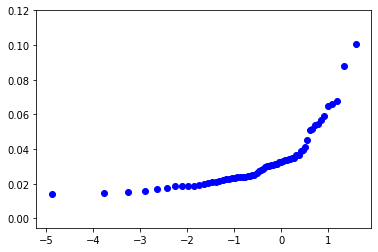

In [284]:
# Plot de Gumbel
Gumbel_plot(maximum_sample)

Nous pouvons ainsi constater que le Gumbel Plot possède une courbure, ce qui signifie que la distribution du maximum rendements est soit de Frechet, soit de Weibull.

Ayant ainsi écarté la possibilité que $\xi = 0$, l'ensemble des paramètres de la distribution GEV peut être estimé par maximum de vraisemblance, sur l'échantillon de maxima.

#### Estimation des paramètres de la distribution GEV

In [285]:
# Estimation des paramètres de la distribution GEV par maximum de vraisemblance
param_GEV = max_log_likelihood(maximum_sample, sps.genextreme.pdf,3)
print(param_GEV)

C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


[-0.31238529  0.02459014  0.00878052]


Les paramètres estimés sont ainsi : $\xi = 0.31$, $\mu = 0.024$ et $\sigma = 0.008$. la positivité du $\xi$ montre que le maximum des rendements suit une loi de Frechet.

Afin de vérifier l'exactitude des paramètres estimées, nous effectuons une estimation en utilisant la fonction "genextreme.fit" du package scipy.stat permettant de fitter une distribution GEV sur les données de maxima et d'en estimer les paramètres.

In [286]:
# fittage de la loi de Skew Student sur les données
param_GEV = sps.genextreme.fit(maximum_sample)
print(param_GEV)

(-0.31237796325071265, 0.024591047942784744, 0.008781520378261382)


Nous pouvons ainsi constater que les paramètres estimés sont très similaires, ce qui permet de valider leur exactitude. La mise en oeuvre de l'évaluation de la VaR par la méthode Bloc Maxima peut dont être entreprise.

#### Test de l'adéquation de la distribution estimée sur les données maxima

##### Graphe des densités

La distribution estimée sur les données maxima doit être testée afin de vérifier qu'elle soit bien adéquate avec la distribution empirique des données. Pour cela, il faut tracer le graphe de la densité théorique et empirique des données maxima pour constater s'il y bien ajustement.

Text(0.5, 1.0, 'Distribution of Maxima Sample')

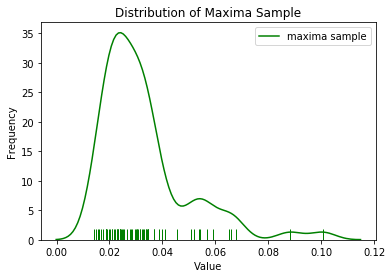

In [305]:
# Traçage de la distribution empirique des blocs maxima
seaborn.distplot(maximum_sample, color = 'green', rug = True, hist = False, label='maxima sample')

pyplot.xlabel('Value')
pyplot.ylabel('Frequency')
pyplot.title('Distribution of Maxima Sample')

Text(0.5, 1.0, 'Theorical fitted GEV Distribution')

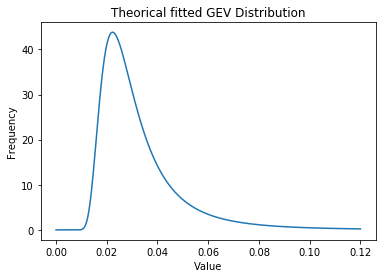

In [318]:
from scipy.stats import genextreme as gev

# Tracage de la distribution GEV théorique
x = np.linspace(0,0.12,1000);
plt.plot(x,gev.pdf(x,-0.31237796325071265, 0.024591047942784744, 0.008781520378261382))
pyplot.xlabel('Value')
pyplot.ylabel('Frequency')
pyplot.title('Theorical fitted GEV Distribution')

Nous pouvons ainsi constater que la distribution empirique et théoriques possèdent à peu près la même allure, ce qui permet de valider visuellement la distribution GEV ajusté sur les données maxima. Par la suite, il est nécessaire de procéder à une validation précise via un test statistique de type Kolmogorov Smirnov qui compare la distribution théorique GEV estimée et celle empirique de l'échantillon maxima.

##### Test statistique d'adéquation

In [320]:
# Test d'adéquation entre l'échantillon et la distribution GEV estimée
stat, p = sps.kstest(maximum_sample, 'genextreme', args = (-0.31237796325071265, 0.024591047942784744, 0.008781520378261382))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print('La distribution théorique est adéquate avec la distribution empirique')
else:
    print('La distribution théorique est inadéquate avec la distributiont empirique')

Statistics=0.056, p=0.985
La distribution théorique est adéquate avec la distribution empirique


Nous pouvons ainsi confirmer l'adéquation entre la distribution théorique de l'échantillon maxima et celle théorique GEV (de Frechet) qui a été estimée sur ces dernières, au regard du test de Kolmogorov Smirnov qui accepte à 95% l'hypothèse nulle d'adéquation des distributions. De ce fait, il est possible d'estimer la VaR par méthode Bloc Maxima en utilisant la distribution précédemment estimée.

#### Estimation de la VaR par méthode BM

Il faut savoir que la Value at Risk de niveau $\alpha$ des rendements selon la méthode BM se fait en réalité en calculant un quantile d'ordre $\alpha_{BM} = \alpha^s$ sur l'échantillon des maximas, sachant que la distribution de cette dernière suit une loi GEV. Cela est dû au fait que $F^{s}(\alpha_{BM}) = F(\alpha)$. Ainsi, la VaR d'horizon $h$ et de niveau $\alpha$ des rendements est exprimée comme suit :

$VaR_h(\alpha)=-G_{\hat{\mu}, \hat{\sigma}, \hat{\epsilon}^{-1}}(\alpha_{BM})$.

Ainsi, le calcul de la VaR selon la méthode BM donne : 

In [288]:
# Spécification des paramètres précédemment estimés
mu_gev, sigma_gev, epsilon_gev = param_GEV

# Calcul des VaR Gaussiennes asymétriques
VaR_GEV_90 = -sps.genextreme.ppf((0.90)**(63), mu_gev, sigma_gev, epsilon_gev) # ppf = percentage point function
VaR_GEV_95 = -sps.genextreme.ppf((0.95)**(63), mu_gev, sigma_gev, epsilon_gev)
VaR_GEV_99 = -sps.genextreme.ppf((0.99)**(63), mu_gev, sigma_gev, epsilon_gev)

# Print des valeurs
print(tabulate([['90%', VaR_GEV_90], ['95%', VaR_GEV_95], ['99%', VaR_GEV_99]], headers = ['Confidence Level','GEV Value at Risk']))

Confidence Level      GEV Value at Risk
------------------  -------------------
90%                          -0.0120428
95%                          -0.015967
99%                          -0.0289049


#### Validation ex-post

La VaR GPD doit être une fois de plus soumis à validation via le backtesting habituel sur échantillon test :

In [455]:
# Application de la fonction pour la VaR GEV
backesting_GEV = Backtesting(Returns_test, VaR_GEV_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_GEV = backesting_GEV/n
print("La proportion d'exceptions est égale à %.3f" % prop_GEV)

# Test d'adéquation
p_value = sps.binom_test(x = backesting_GEV, n = n, p=0.01)
print('p-value=%.3f' % p_value)
# Interprétation
alpha = 0.05
if p > alpha:
    print("Le nombre d'exceptions au regard de la VaR GEV suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR GEV ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.007
p-value=0.431
Le nombre d'exceptions au regard de la VaR GEV ne suit pas une Binomiale avec p = 1%


La p-valeur ne permet pas de valider la VaR calculée par la méthode des blocs Maxima. Cependant, nous pouvons constater que la proportion d'exceptions, égale à $0.7\%$, se rapproche davantage du benchmark de $1\%$.

Une autre approche pour calculer la VaR TVE s'appelle la méthode PEak Over Threshold, qui sera étudiée dans le paragraphe qui suit. L'idée est que plutôt que d’estimer la loi du maximum de l’échantillon, on va s'intéresser au comportement des pertes au-delà d'un certain seuil.

### Modélisation : Méthode Peak Over Threshold

Nous nous intéressons ici au comportement des pertes au delà d'un certain seuil. Ainsi, pour un seuil u arbitrairement choisi, une fonction stockant les rendements en excès par rapport à ce seuil est implémenté.

#### Capture des rendements en excès par rapport au seuil u

In [140]:
# On crée un vecteur contenant les rendements ayant dépassé le seul u
def excess_returns(data, u):
    n = len(data)
    Z = []
    for i in range (n):
        if data[i] > u:
            Z.append(data[i])
    return Z

Ce faisant, on suppose dans la pratique que les excès suivent exactement une loi GPD pour un seuil suffisamment élevé, qui doit être déterminé.

#### Détermination du seuil optimal u

La détermination se fait à l'aide d'un outil graphique, le Mean-excess plot, défini par $(u, e_n(u)), u \in [x_{(1)}, x_{(n)}]$, avec $e_n(u) = \frac{1}{N_u} \sum_{i=1}^{n}(x_i-u)_{+} = \frac{1}{N_u} \sum_{i=1}^{N_u}(z_i-u)$ (avec $z_i$ les composantes de l'échantillon des rendements en excès) qui est l'estimateur empirique de $e(u) = E[X-u|X>u]$ la moyenne des excès, égale à $\frac{\sigma + \epsilon u}{1 - \epsilon}$ pour la loi GDP.

Les excès au delà de u suivent une loi GPD lorsque le Mean-excess plot est linéaire. L'estimateur $e_n(u)$ est implémentée comme suit.

In [35]:
# Implémentation du quantile empirique
def e_n(data, u):
    excess_data = excess_returns(data, u)
    N_u = len(excess_data)
    e_n = 0
    for i in range (N_u):
        e_n += (1/N_u)*(excess_data[i]- u)
    return e_n

Ce qui permet ainsi de tracer le plot du Mean-excess :

In [36]:
# Implémentation du mean excess plot
def mean_excess_plot(data, size):
    u = np.linspace(0, np.percentile(data, 98), size)
    en = []
    for i in u:
        en.append(e_n(data, i))
    plt.plot(u,en)

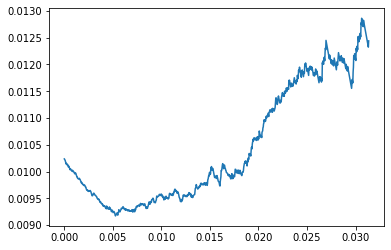

In [37]:
mean_excess_plot(Returns_train, 1000)

Ainsi, au vu du graphique, le seuil optimal u à prendre est égal à 0.018.

#### Estimation du maximum de vraisemblance

Sachant que le seuil u pour lequel les retours en excès suivent une loi GPD a été choisi, les paramètres de ladite loi doivent être estimés par maximum de vraisemblance. Il convient tout d'abord de définir cette densité ;

$$
h_{\sigma, \xi}(y) = \frac{1}{\sigma}[1+\xi \frac{y}{\sigma}]^{-\frac{(1+\xi)}{\xi}}
$$.

Cette fonction est ensuite implémentée sur Python :

In [268]:
# Densité de Pareto
def f_pareto(x, *params):
    # Chargement des paramètres
    sigma, xi = params
    
    # Calcul de la densité
    dens = (1/sigma)*(1+xi*(x/sigma))**(-(1+xi)/xi)
    return dens

In [269]:
## Création de l'échantillon des rendements en excès au delà du seuil u = 0.018
excess_return = excess_returns(Returns_train, 0.018)

# Estimation des paramètres de la distribution GEV par maximum de vraisemblance
param_GPD = max_log_likelihood(excess_return, f_pareto,2)
print(param_GPD)

[ 0.03502085 -0.33328487]


C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


Ainsi, les paramètres de la loi de Pareto estimés par maximum de vraisemblance sont : $\sigma = 0.035$ et $\xi =-0.33$

#### Estimation des paramètres par la méthode des moments

Une autre approche pour estimer les paramètres de la loi de Pareto Généralisée sur l'échantillon des minima est d'utiliser la méthode des moments. Pour cela, sachant qu'il y a deux paramètres $\sigma$ et $\xi$ à estimer, les moments empiriques d'ordre 1 et 2 seront calculés et doivent être égaux aux deux moments théoriques calculés avec les deux inconnus. Le système d'équation sera par la suite résolu afin d'obtenir une estimation des paramètres en question.

Rappelons par dérivation que le moment d'ordre $r$ de la Pareto généralisée est égale à :

$$
\omega_r(\sigma,\xi) = \frac{\sigma}{(r+1)(r+1+\xi)}
$$

Ce qui permet d'obtenir l'expression des deux paramètres : 

$$
\sigma = \frac{2\omega_0 \omega_1}{\omega_0- 2\omega_1}
$$ 
$$
\xi = 2- \frac{\omega_0}{\omega_0- 2\omega_1}
$$

D'un autre côté, les moments d'ordre $r$ empiriques se calculent comme suit, en considérant $(z_1,...,z_n)$ l'échantillon des excès:

$$
\hat{\omega}_r(\sigma,\xi) = \frac{1}{N_u}\sum_{i=1}^{N_u} z_i \hat{F}^r(z_i), \ r\in (0,1)
$$

avec $\hat{F}^r$ la fonction de répartition empirique de la loi de Pareto Généralisée.

Ainsi, il convient d'implémenter la fonction de répartition empirique, évaluée à une certaine observation $z_i$:

In [666]:
def ecdf(data, i):
    n = len(data)
    x = np.sort(data)
    cumul = np.cumsum(x)/n
    cdf = cumul[i]
    return cdf

Ainsi, les moments empiriques d'ordre $r$ peuvent être implémentés :

In [667]:
def empirical_moment(data, r):
    N_u = len(data)
    mom = 0
    for i in range (N_u):
        mom += data[i]*np.power(ecdf(data, i),r)
    return (1/N_u)*mom

In [678]:
w_0 = empirical_moment(excess_return, 0)
w_1 = empirical_moment(excess_return, 1)

sigma = (2*w_0*w_1)/(w_0 - 2*w_1)
xi = 2 - (w_0/(w_0 - 2*w_1))

print(sigma, xi)

0.0006254936841834473 0.9776188256046514


Les résultats entre les estimations par maximum de vraisemblance et par la méthode des moments sont significativement différents, notamment pour le paramètre $\xi$. De ce fait, pa sécurité, il a été décidé de garder les estimations par maximum de vraisemblance.

In [679]:
# Définition des paramètres pour la suite du problème
sigma = 0.035
xi = -0.33

#### Validation ex ante

##### Graphe des densités

Une fois de plus, la distribution estimée sur les données minimas (ou pertes en excès) doit être testée afin de vérifier qu'elle soit bien adéquate avec la distribution empirique des données. Pour cela, il faut tracer le graphe de la densité théorique et empirique des données maxima pour constater s'il y bien ajustement.

Text(0.5, 1.0, 'Distribution of Minima Sample')

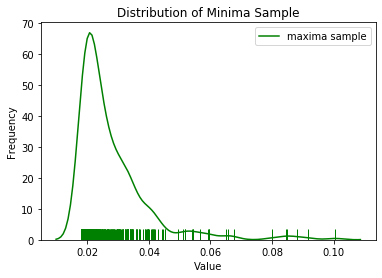

In [680]:
# Traçage de la distribution empirique des données minima
seaborn.distplot(excess_return, color = 'green', rug = True, hist = False, label='maxima sample')

pyplot.xlabel('Value')
pyplot.ylabel('Frequency')
pyplot.title('Distribution of Minima Sample')

C:\Users\Si Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


Text(0.5, 1.0, 'Theorical fitted GPD Distribution')

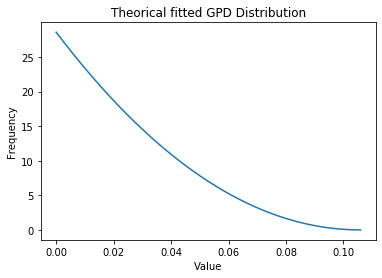

In [681]:
param_GPD = [sigma,xi]

# Tracage de la distribution GEV théorique
x = np.linspace(0,0.12,1000);
plt.plot(x,f_pareto(x, *param_GPD))
pyplot.xlabel('Value')
pyplot.ylabel('Frequency')
pyplot.title('Theorical fitted GPD Distribution')

Malheureusement, le graphe de la distribution empirique et celle théorique ne concorde pas visuellement... Il serait avisé d'effectuer des tests statistiques plus poussés afin d'étudier l'adéquation entre la distribution théorique et empirique pour pouvoir valider cette modélisation.

##### Test statistique d'adéquation

De même, il convient de tester statistiquement l'adéquation entre la distribution empirique de l'échantillon minima et la distribution théorique de la loi GPD avec les paramètres estimés sur l'échantillon. Le traçage du QQPlot, le test de Kolmogorov-Smirnov ou le test de Chi-deux sont tout a fait adaptés.

Cependant, à cause du fait que la loi GPD a été implémentée à la main et qu'elle ne figure pas dans les fonctions du package scipy.stat, il est uniquement possible d'effectuer un test de Chi-deux d'indépendance entre l'échantillon des minimas, et un échantillon dit 'théorique', résultant de la simulation d'une variable aléatoire de loi GPD avec les paramètres estimés par maximum de vraisemblance.

Pour la simulation, la méthode de la transformée inverse sera utilisée car on possède une formule explicite de l'inverse de la fonction de répartition de la loi GPD.

Il s'agira donc dans un premier temps de générer un échantillon $(U_1,...U_n)$ de loi uniforme $U[0,1]$, sur laquelle sera
appliqué l'inverse de la fonction de répartition. Ainsi, l'échantillon : $(H_{\hat{\sigma}, \hat{\xi}}^{-1}(U_1),...H_{\hat{\sigma}, \hat{\xi}}^{-1}(U_n))$ sera de loi GPD.

L'échantillon théorique, devant être de taille $n$ égale à celle de l'échantillon empirique des maximas, servira pour effectuer le test de Chi Deux ainsi que pour le QQPlot

La fonction de répartition de la loi GPD de paramètres $(\hat{\sigma}, \hat{\xi})$ est  exprimée telle que :

$$
H_{\hat{\sigma}, \hat{\xi}}(y) = 
\left\{
    \begin{array}{ll}
    1- (1+ \xi \frac{y}{\hat{\sigma}})^{-\frac{1}{\hat{\xi}}} & \mbox{si } \xi \ne 0  \\
    1- exp(-\frac{y}{\hat{\sigma}}) & \mbox{si } \xi = 0 
    \end{array}
\right.
$$

Ce qui permet ainsi d'obtenir le quantile d'ordre $\alpha$ de la loi GPD en inversant sa fonction de répartition. Cette opération permet d'obtenir :

$$
H_{\hat{\sigma}, \hat{\xi}}^{-1}(\alpha) = 
\left\{
    \begin{array}{ll}
    \frac{\hat{\sigma}}{\hat{\xi}}[(1- \alpha)^{-\xi} -1] & \mbox{si } \xi \ne 0  \\
    - \hat{\sigma} ln(1-\alpha) & \mbox{si } \xi = 0 
    \end{array}
\right.
$$

La simulation de la loi GPD peut donc être effectuée:

In [682]:
# Quantile d'ordre alpha de la loi GPD
def GPD_ppf(alpha, sigma, xi):
    if xi != 0:
        GDP_ppf_value = (sigma/xi)*((1-alpha)**(-xi)-1)
    else :
        GDP_ppf_value = -sigma*math.log(1-alpha)
    return GDP_ppf_value

In [683]:
unif_sample = np.random.rand(len(excess_return))
theorical_estimated_GPD_sample= []
for i in range (len(excess_return)):
    theorical_estimated_GPD_sample.append(GPD_ppf(unif_sample[i], sigma, xi))

Ainsi, le test d'adéquation de Chi-Deux peut être effectuée :

In [684]:
# Test d'adéquation entre l'échantillon et la distribution GEV estimée
stat, p = sps.chisquare(excess_return, theorical_estimated_GPD_sample)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print('La distribution théorique est adéquate avec la distribution empirique')
else:
    print('La distribution théorique est inadéquate avec la distributiont empirique')

Statistics=18.928, p=1.000
La distribution théorique est adéquate avec la distribution empirique


L'adéquation de la distribution théorique selon les paramètres estimés avec la distribution théorique de l'échantillon des minima permet de l'approuver, et d'effectuer le calcul de la VaR selon la méthoède Peak Over Threshold, qui passe dans un premier temps par un redressement du niveau de quantile.

#### Redressement du niveau de quantile

Etant donné que la Value at Risk est ici calculée avec l'échantillon des Maximas, l’estimation de la VaRà partir de la GEV ne doit pas se faire de niveau $\alpha$ mais de niveau $\alpha_{POT}$ qui est défini par

$$
1 - \alpha_{POT} = \frac{n}{N_u} (1- \alpha)
$$

C'est à dire :

$$
\alpha_{POT} = 1 - \frac{n}{N_u} (1- \alpha)
$$

avec :
- $n$ la taille de l'échantillon totale
- $N_u$ la taille de l'échantillon des pertes extrêmes

Le niveau $\alpha_{POT}$ peut donc être calculée grâce à la fonction suivante :

In [685]:
def alpha_POT(alpha, data):
    # Détermination des pertes extrêmes selon le seuil u = 0.018
    excess_return = excess_returns(data, 0.018)
    
    # taille de l'échantillon initial et celui des pertes extrêmes
    n = len(data)
    N_u = len(excess_return)
    
    # Calcul du niveau alpha_pot
    alphapot = 1 - (n/N_u)*(1-alpha)
    
    # Return
    return alphapot

#### Calcul de la VaR

La Value at Risk de niveau de confiance $\alpha$ à horizon d’investissement $h$ modélisée par la loi GPD est donnée par :
    
$$
VaR_h(\alpha) = - H_{\hat{\sigma}, \hat{\xi}}^{-1}(\alpha_{POT})
$$

avec $H_{\hat{\sigma}, \hat{\xi}}^{-1}(\alpha_{POT})$ le quantile d'ordre $\alpha_{POT}$ de la loi GPD qui peut être obtenu en inversant sa fonction de répartition. Rappelons que l'inverse de sa fonction de répartition est telle que :

$$
H_{\hat{\sigma}, \hat{\xi}}^{-1}(\alpha) = 
\left\{
    \begin{array}{ll}
    \frac{\hat{\sigma}}{\hat{\xi}}[(1- \alpha)^{-\xi} -1] & \mbox{si } \xi \ne 0  \\
    - \hat{\sigma} ln(1-\alpha) & \mbox{si } \xi = 0 
    \end{array}
\right.
$$

Ainsi, la Value at Risk TVE selon la méthode de la distribution des excès peut être calculée :

In [686]:
# Spécification des paramètres précédemment estimés
alpha_POT_90 = alpha_POT(0.90, Returns_train)
alpha_POT_95 = alpha_POT(0.95, Returns_train)
alpha_POT_99 = alpha_POT(0.99, Returns_train)

# Calcul des VaR TVE selon la loi GPD
VaR_GPD_90 = - GPD_ppf(alpha_POT_90, sigma, xi)
VaR_GPD_95 = - GPD_ppf(alpha_POT_95, sigma, xi)
VaR_GPD_99 = - GPD_ppf(alpha_POT_99, sigma, xi)

# Print des valeurs
print(tabulate([['90%', VaR_GPD_90], ['95%', VaR_GPD_95], ['99%', VaR_GPD_99]], headers = ['Confidence Level','GPD Value at Risk']))

Confidence Level      GPD Value at Risk
------------------  -------------------
90%                          0.00800482
95%                         -0.0153174
99%                         -0.0527082


#### Validation Ex Post

La VaR GPD doit être soumis à validation via le backtesting habituel sur échantillon test :

In [611]:
# Application de la fonction pour la VaR Skew Student
backesting_GPD = Backtesting(Returns_test, VaR_GPD_99)
n = len(Returns_test)

# Calcul de la proportion d'exceptions
prop_GPD = backesting_GPD/n
print("La proportion d'exceptions est égale à %.3f" % prop_GPD)

# Test d'adéquation
p_value = sps.binom_test(x = backesting_GPD, n = n, p=0.01)
print('p-value=%.3f' % p_value)
# Interprétation
alpha = 0.05
if p > alpha:
    print("Le nombre d'exceptions au regard de la VaR GPD suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR GPD ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.001
p-value=0.001
Le nombre d'exceptions au regard de la VaR GPD suit bien une Binomiale avec p = 1%


Malheureusement, nous pouvons constater une fois de plus que la VaR selon la méthode de la distribution des excès ne peut être validé par le test car elle est trop conservatrice.

Le caractère trop conservatrice des VaR peut être expliqué par la présence dans l'échantillon d'apprentissage d'évènements exceptionnelles ayant entraînés des pertes extrêmes, telles que la crise de 2007-2008, ou bien la crise liée à l'éclatement de la bulle internet en 2001. Cela a ainsi pour conséquence le calcul d'une VaR très conservatrice, qui ne peut être appliquée sur l'échantillon test qui elle, est dépourvue d'évènements extrêmes.

Cela peut s'expliquer que la VaR n'est pas statique et varie temporellement. Cela est dû au fait que les rendements ne sont en réalité pas indépendant et identiquement distribués, contrairement à l'hypothèse qui a été faite pour le calcul des VaR précédentes. En effet, les rendements présentent des autocorrélations qu'il convient de modéliser par l'analyse de séries temporelles. C'est ainsi que la VaR doit être calculé chaque jour par ce que l'on appelle le calcul de la VaR dynamique.

Par ailleurs, les rendements sont une distributions à queues épaisses et il est possible de constater des phénomènes de volatility clustering. Tous ces éléments plaident en faveur d'un Calcul d'une VaR dynamique avec modélisation de la volatilité conditionnelle, et met en exergue les limites du calcul d'une VaR statique temporellement, qui est irréaliste dans le cas pratique. A contrario, le calcul d'une VaR sur une période de temps dépourvue d'évènements extrêmes peut se révéler davantage dévastateur en cas de crise ou de période stressée.

## Calcul de la VaR dynamique

La Value at Risk dynamique sera estimée à partir de l'échantillon d'apprentissage des rendements logarithmiques qui a été préalablement définie dans la première partie. Etant une série temporelle, cet échantillon sera analysée en tant que tel.

### Etudes de la série temporelle

##### Statistiques descriptives

La série temporelle peut être visualisée dans un premier temps :

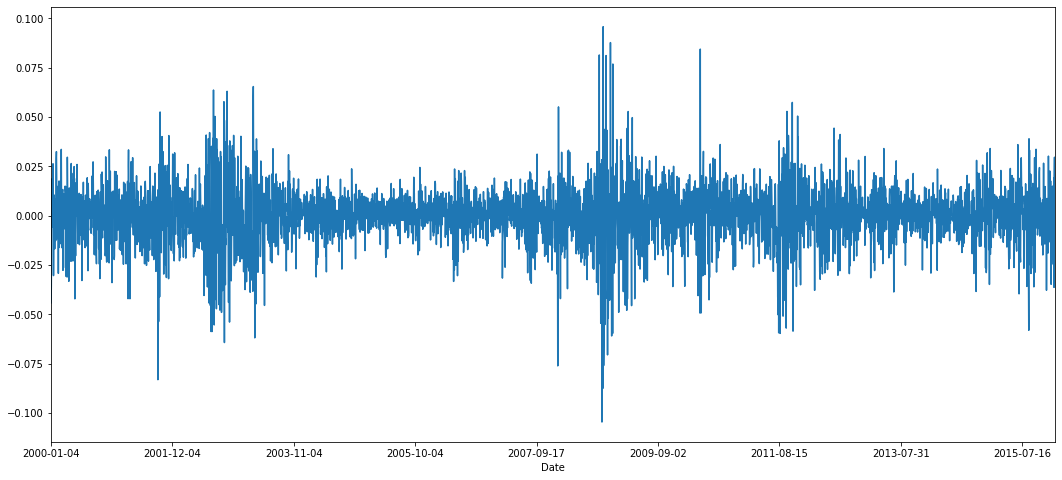

In [26]:
Log_Returns_train.plot(figsize = (18,8))

La série temporelle des rendements logarithmiques semble visuellement stationnaire, avec une moyenne semblant être égale à 0. L’hétéroscédasticité conditionnelle peut être observée au vue des périodes de fortes volatilités, aux alentours de 2011-2012, puis de 2018-2019 par exemple, puis d’autres de faibles volatilités. Ainsi, sans surprise, la série semble pouvoir être modélisée par un modèle GARCH, comme pour la grande majorité des séries financières, sous réserve de validation des tests statistiques.

Une première étude descriptive peut être faite sur la série temporelle. Par ailleurs, le graphe qqplot peut être tracé afin de vérifier l'adéquation de la loi de la distribution de lasérie avec celle de la loi normale.

In [20]:
Log_Returns_train.describe()

count    4138.000000
mean       -0.000300
std         0.015004
min        -0.104634
25%        -0.007373
50%         0.000204
75%         0.007553
max         0.095789
Name: Log_Returns, dtype: float64

Nous pouvons préalablement constater que la moyenne de la série semble visuellement très proche de zéro, pouvant ainsi faire penser qu'il s'agit d'un bruit blanc. En général, il est assez fréquent de voir que les rendements logarithmiques possèdent des moyennes nulles. Il convient donc de vérifier si la série est un bruit blanc ou non par l'étude de sa stationarité, puis la détection d'autocorrélations. Et en cas de présence, analyser leur nombre.

##### Etude de la stationnarité et analyse des autocorrélations de la série

La présence ou non de stationnarité concernant la série temporelle peut être détectée via un test de Dickey Fuller :

In [30]:
import statsmodels.api as sm

results = sm.tsa.stattools.adfuller(Log_Returns_train)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print("La série n'est pas stationnaire")
else:
    print("La série est stationnaire")

Statistics=-21.623, p=0.000
La série est stationnaire


Nous pouvons ainsi confirmer que la série est stationnaire. Ce qui permet, en cas de présence d'autocorrélation dans la série, de la modéliser par un processus AR.

Le test de Ljung Box permet d'établir si la série temporelle est un bruit blanc ou non, c'est à dire si elle est dépourvue d'autocorrélations.

In [27]:
stat, p = sm.stats.acorr_ljungbox(Log_Returns_train, lags=[10])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print('La série est un bruit blanc')
else:
    print('La série présente des autocorrélations')

Statistics=52.549, p=0.000
La série présente des autocorrélations


Nous pouvons ainsi constater que la série des rendements logarithmiques n'est pas un bruit blanc et est donc pourvue d'autocorrélations. Sachant qu'elle est stationnaire, il est possible de la modéliser par un modèle AR d'ordre $p$ à déterminer. Il convient donc de tracer le graphe ACF afin de compter le nombre d'autocorrélation et ainsi l'ordre $p$ de l'AR à modéliser.

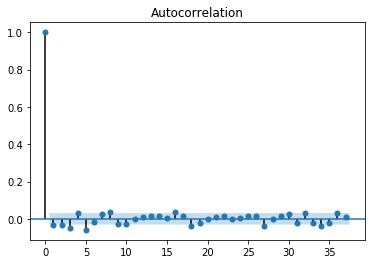

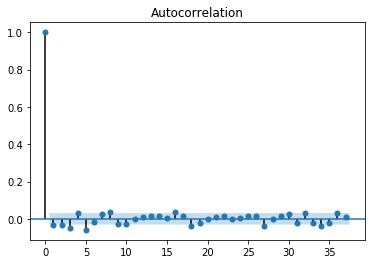

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(Log_Returns_train)

le graphe ACF semble montrer qu'aucune autocorrélation hormis la variance ne semble significative. Pour autant, le test de Ljung box a détecté la présence d'autocorrélation. Il semble donc judicieux de modéliser la série temporelle des rendements logarithmiques par un AR(1). Plus précisément, le modèle AR(1) permet ainsi de modéliser la moyenne des rendements logarithmiques conditionnellement à son passé au temps précédent.

Cependant, la présence d'hétéroscédasticité conditionnelle a été constatée visuellement, ce qui laisserait sous entendre la présence d'un effet ARCH, sous condition de confirmation des tests statistiques. Pour cela, il convient de tester cette présence. La première étape consiste au traçage du QQplot sur la série des log-rendements.

##### Traçage du QQPlot

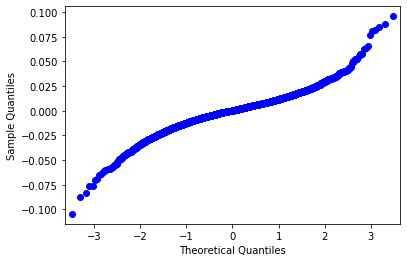

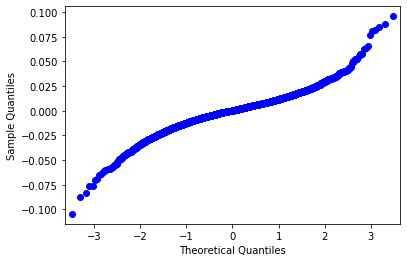

In [21]:
sm.qqplot(Log_Returns_train)

Il a été constaté comme précédemment que les rendements logarithmiques que QQ-plot montre que la série des rendements logarithmiques ne suit pas du tout une loi normale, et que les queues de sa distribution semblent très épaisses, illustrant une forte volatilité stochastique. L’effet ARCH semble se confirmer pour la série.

Il convient d'effectuer des tests statistiques afin de confirmer cet effet ARCH. En général, il convient d'étudier si le carré d'un bruit blanc présente des autocorrélation Cependant, ce test ne peut se faire que si la série temporelle est un bruit blanc. Ainsi, il convient dans un premier temps de modéliser la moyenne conditionnelle de la série des log-rendements par un AR(1), avant de tester la présence d'effet ARCH sur les résidus de cet AR(1)

### Modélisation d'un AR(1) sur la série

Comme convenu précédemment, un modèle AR(1) sera estimé sur la série temporelle.

In [663]:
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot

# fit model
model_ar = ARMA(Log_Returns_train, order=(1,0))
model_ar_fit = model_ar.fit()
model_ar_fit.summary()

C:\Users\Si Dan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Log_Returns   No. Observations:                 4139
Model:                     ARMA(1, 0)   Log Likelihood               11510.711
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 27 Mar 2020   AIC                         -23015.422
Time:                        22:53:44   BIC                         -22996.437
Sample:                             0   HQIC                        -23008.704
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.000     -1.306      0.192      -0.001       0.000
ar.L1.Log_Returns    -0.0321      0.016     -2.067      0.039      -0.063      -0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -31.1114           +0.0000j           31.1114            0.5000
-----------------------------------------------------------------------------
"""

Nous pouvons ainsi constater que les coefficients du modèle $AR(1)$ sont toutes significatives, ce qui permet d'établir la pertinence d'une telle modélisation sur la série des rendements logarithmiques. Plus précisément, le modèle estimé ici satisfait :

$$
y_t = -0.0003 -0.0318 y_{t-1} + r_t
$$

avec $r_t$ qui doit être un bruit blanc. Afin de valider complètement ce modèle, le caractère Bruit Blanc des résidus $r_t$ du modèle doit être testé par un test de blancheur de Ljung Box.

Dans un premier temps, on crée un DataFrame contenant les résidus du modèle, qui seront ensuite visualisés :

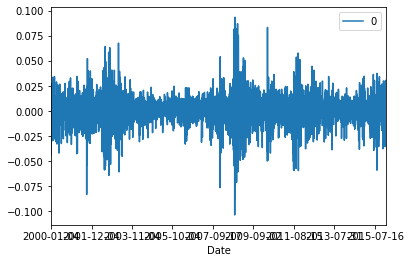

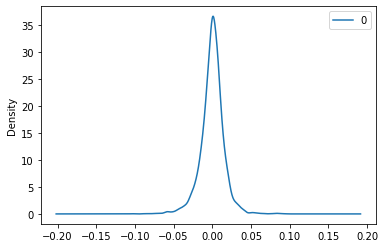

                  0
count  4.138000e+03
mean  -3.333641e-07
std    1.499599e-02
min   -1.034209e-01
25%   -7.034945e-03
50%    5.619564e-04
75%    7.872652e-03
max    9.331134e-02


In [111]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

La moyenne des résidus du modèle semble être quasi nulle et la présence d'un effet ARCH peut être constaté visuellement. Ajoutons à cela le fait que la série est stationnaire selon le graphique.

Pour tester la blancheur des résidus, le test de Ljung Box peut être effectué :

In [113]:
# Test de Ljung Box
stat, p = sm.stats.acorr_ljungbox(model_ar_fit.resid, lags=[10])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print('La série est un bruit blanc')
else:
    print('La série présente des autocorrélations')

Statistics=48.660, p=0.000
La série présente des autocorrélations


Malheureusement, l'hypothèse nulle a été rejetée, montrant ainsi que les résidus du modèle $AR(1)$ estimé ne sont pas des bruits blancs et que le modèle n'a pas été en mesure de modéliser la moyenne conditionnelle de la série des rendements logarithmiques. Cependant, n'ayant pas trouvé de solutions à ce problème, la validité du modèle sera admise pour pouvoir continuer la suite de l'étude. Il sera judicieux de modéliser un modèle AR(1)-GARCH(1,1) directement sur les rendements logarithmiques sans effectuer d'étapes intermédiaires pour comparer les coefficients. Si ces derniers sont similaires, le modèle sera gardé pour le calcul de la VaR dynamique.

Dans la suite de l'étude, un modèle GARCH sera modélisé sur les résidus du modèle $AR$ sous réserve de pouvoir détecter de la volatilité conditionnelle sur ces derniers.

#### Détection d'effet ARCH sur les résidus du modèle AR

L'étape suivante consiste donc à détecter la présence d'effet ARCH sur ces résidus. Pour cela, la présence d'autocorrélation sur le carré des résidus doit être vérifiée. Cependant, pour davantage de simplicité et pour obtenir des résultats consistants, il s'agira du test d'Engle de détection d'hétéroscédasticité conditionnel qui sera appliqué sur les résidus du modèle.

In [71]:
# Test d'Engle
results = sm.stats.diagnostic.het_arch(model_ar_fit.resid)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print("Pas d'effet ARCH sur les résidus")
else:
    print("présence d'effet ARCH sur les résidus")

Statistics=894.893, p=0.000
présence d'effet ARCH sur les résidus


Ainsi, le test confirme la présence d'un effet ARCH sur les résidus du modèle AR. Il convient donc de modéliser un modèle GARCH(1,1) sur ces résidus afin de modéliser l'hétéroscédasticité conditionnelle des rendements logarithmiques.

### Modélisation d'un GARCH(1,1) sur les résidus du modèle AR(1)

Comme convenu précédemment, un modèle AR(1) sera estimé sur les résidus du modèle AR(1). Ces résidus sont généralement supposés suivre une loi Student, sachant qu'il a été vu précédemment au vu du QQPlot qu'ils ne suivent pas une loi normale et qu'ils possèdent une distribution à queue lourde. Cependant, du fait de problèmes rencontrés lors de la modélisation en supposant des résidus de Student, il a été décidé de prendre des résidus Gaussiens.

In [489]:
from arch import arch_model

# define model
model_arch = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
model_arch_fit = model_arch.fit(update_freq=5)
model_arch_fit.summary()

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -12170.72192603534
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\Si Dan\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\Si Dan\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12170.7
Distribution:                  Normal   AIC:                          -24335.4
Method:            Maximum Likelihood   BIC:                          -24316.5
                                        No. Observations:                 4138
Date:                Fri, Mar 27 2020   Df Residuals:                     4135
Time:                        16:47:11   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4965e-06  7.232e-12  6.218e+05      0.000 [4.496e-06,4.497e-06]
alpha[1]       0.1000  4.675e-04    213.914      0.000   [9.908e-02,  0.101]
beta[1]        0.8800  3.231e-03    272.397      0.000     [  0.874,  0.886]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

Nous pouvons ainsi constater que les coefficients du modèle $GARCH(1,1)$ sont toutes significatives, ce qui permet d'établir la pertinence d'une telle modélisation sur la série des résidus du modèle $AR$. Plus précisément, le modèle estimé ici satisfait :

$$
r_t = \sigma_t \epsilon_t \\
\sigma_t^2 = 4.4965*10^{-6} + 0.88 \sigma_{t-1}^2  + 0.1 r_{t-1}^2
$$

avec $\epsilon_t$ un bruit blanc fort de loi Normale centrée réduite qui sont les résidus corrigés de la volatilité. 

Cependant, il convient malheureusement de constater la difficulté de convergence du modèle.

Le modèle ayant été estimé, son diagnostic doit être réalisé à partir de ses résidus

##### Diagnostic du modèle

La première chose à effectuer est de vérifier si les résidus corrigés de la volatilité du modèle GARCH présentent de l'hétéroscédasticité conditionnel ou non.

Les résidus de la volatilités sont les résidus GARCH auquels on la divise par la volatilité conditionnelle estimée par le modèle.

Après calcul des résidus corrigés, le test d'Engle est effectué :

In [479]:
corrected_GARCH_residuals = model_arch_fit.resid/model_arch_fit.conditional_volatility

# Test d'Engle
results = sm.stats.diagnostic.het_arch(corrected_GARCH_residuals)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print("Pas d'effet ARCH sur les résidus corrigés")
else:
    print("présence d'effet ARCH sur les résidus corrigés")

Statistics=32.121, p=0.411
Pas d'effet ARCH sur les résidus corrigés


Ainsi, il est possible de constater qu'il n'y a pas d'effets ARCH sur les résidus corrigés, témoignant ainsi de la validité du modèle GARCH(1,1) nouvellement modélisé, qui a été capable de modéliser correctement la volatilité conditionnelle des rendements logarithmiques.

Par ailleurs, il est nécessaire de vérifier que ces résidus corrigés de la volatilité sont des bruits blancs forts, ce qui permet par ailleurs de prouver qu'en dépit du test de Ljung Box effectué précédemment, les résidus du modèle $AR$ ayant permis d'estimer le modèle GARCH sont tout aussi des bruits blancs :

In [664]:
# Test de Ljung Box
stat, p = sm.stats.acorr_ljungbox(corrected_GARCH_residuals, lags=[10])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print('Les résidus corrigés sont des bruits blancs')
else:
    print('Les résidus corrigés présentent des autocorrélations')

Statistics=10.129, p=0.429
Les résidus corrigés sont des bruits blancs


Les résidus corrigés sont finalement des bruits blancs au vu du test de Ljung Box, ce qui permet de valider le modèle GARCH et donc finalement l'ensemble du modèle AR-GARCH estimé jusqu'à présent.

Finalement, comme la structure retenu est un modèle AR(1)-GARCH(1,1), il a été convenu de le modéliser en une seule étape sur les rendements logarithmiques et ainsi estimer les paramètres sur l'ensemble de la structure spécifiée.

#### Estimation des paramètres sur l'ensemble de la structure spécifiée

In [490]:
model_final = arch_model(Log_Returns_train, mean = 'AR', lags =1, vol = 'Garch', p=1,o=0,q=1, dist = 'normal')
model_final_fit = model_final.fit(update_freq=5)
model_final_fit.summary()

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -12177.399427072844
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 4


C:\Users\Si Dan\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002244. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\Si Dan\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                12177.4
Distribution:                  Normal   AIC:                          -24344.8
Method:            Maximum Likelihood   BIC:                          -24313.2
                                        No. Observations:                 4137
Date:                Fri, Mar 27 2020   Df Residuals:                     4132
Time:                        16:49:26   Df Model:                            5
                                    Mean Model                                   
=================================================================================
                    coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         3.4505e-04  1.645e-04      2.097  3.600e-02   [2.254e-05,6.676e-04]
Log_...rns[1]    -0.0318  1.584e-02     -2.007  4.477e-02 [-6.283e-02,-7.427e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4884e-06  9.485e-14  4.732e+07      0.000 [4.488e-06,4.488e-06]
alpha[1]       0.1000  5.251e-04    190.451      0.000   [9.897e-02,  0.101]
beta[1]        0.8800  3.294e-03    267.148      0.000     [  0.874,  0.886]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

Nous pouvons ainsi constater que les coefficients estimés sur l'ensemble de la structure spécifiée sont quasiment égales à ceux estimés sur les modèles AR et GARCH modélisés séparéments dans la partie précédente, hormis pour les constantes $\mu$ et $\omega$ qui sont légèrement différentes, ce qui permet de valider l'ensemble des modèles estimés.

Ainsi, la série des rendements logarithmiques suit un modèle final AR(1)-GARCH(1,1) qui peut être exprimé comme suit :

$$
\left\{
    \begin{array}{lll}
        r_t = \mu_t + \sigma_t \epsilon_t \\
        \mu_t = 3.4505*10^{-4} -0.0318 r_{t-1} \\
        \sigma_t^2 = 4.4884*10^{-6} + 0.88 \sigma_{t-1}^2  + 0.1 (r_{t-1} - \mu_{t-1})^2
    \end{array}
\right.
$$

avec $\epsilon_t$ un bruit blanc fort centré réduite de loi normale qui sont les résidus corrigés de la volatilité.

### Calcul de la VaR Dynamique

##### Calcul de la VaR sur les résidus du modèle AR-GARCH

La VaR de niveau $\alpha$, donc le quantile d'ordre $1 - \alpha$ des résidus corrigés de la volatilité du modèle AR-GARCH peut être calculé. Sachant que les log_rendements possèdent une distribution à queue épaisses et ne sont que rarement Gaussienne, il a été convenu d'utiliser une VaR Skew Student qui serait à priori plus adaptés. Cela est d'autant plus motivé par le fait que la distribution spécifiée pour la modélisation GARCH est de Student. La non adéquation avec la normalité peut être vérifiée par un test de Shapiro Wilk sur les résidus.

Pour cela, nous estimons les paramètres de la distribution Skew Student par maximum de vraisemblance, conformément aux données des résidus corrigés de la Volatilité:

In [465]:
corrected_GARCH_residuals = pd.DataFrame(model_arch_fit.resid/model_arch_fit.conditional_volatility)

# Estimation des paramètres de la Skew Gaussienne par maximum de vraisemblance
param_skew_student_dyn = max_log_likelihood(corrected_GARCH_residuals, f_skewstud,4)
print(param_skew_student_dyn)

[-0.53972719  0.94947974  0.08366546 15.41786501]


A partir de ces quantités, il est ainsi posible de calculer les VaR Skew Student sur les résidus corrigés :

In [501]:
# Calcul des VaR Gaussiennes asymétriques
VaR_SS_90 = VaR_SS_alpha(param_skew_student_dyn, 0.90) 
VaR_SS_95 = VaR_SS_alpha(param_skew_student_dyn, 0.95) 
VaR_SS_99 = VaR_SS_alpha(param_skew_student_dyn, 0.99) 

# Print des valeurs
print(tabulate([['90%', VaR_SS_90], ['95%', VaR_SS_95], ['99%', VaR_SS_99]], headers = ['Confidence Level','Skew Student Value at Risk']))

Confidence Level      Skew Student Value at Risk
------------------  ----------------------------
90%                                     -1.73125
95%                                     -2.08044
99%                                     -2.7885


Les VaR d'ordres 90%, 95% et 99% ont été calculés. Ainsi, il est possible d'en déduire la VaR dynamique de la série des rendements logarithmiques.

##### Calcul de la VaR dynamique

L'étude précédente de la série des rendements logarithmiques a permis d'établir que celle ci suit un modèle AR(1)-GARCH(1,1) qui peut être exprimé comme suit :

$$
\left\{
    \begin{array}{lll}
        r_t = \mu_t + \sigma_t \epsilon_t \\
        \mu_t = 3.4505*10^{-4} -0.0318 r_{t-1} \\
        \sigma_t^2 = 4.4884*10^{-6} + 0.88 \sigma_{t-1}^2  + 0.1 (r_{t-1} - \mu_{t-1})^2
    \end{array}
\right.
$$

avec $\epsilon_t$ un bruit blanc fort centré réduite qui sont les résidus corrigés de la volatilité.

De ce fait, l'estimation de la VaR des rendements à l'instant $t+1$ se fait à partir des estimations du temps précédent $t$ ainsi que de l'ensemble des paramètres estimé par le modèle AR-GARCH. Dans notre cas, au temps $t+1$, nous avons :

$$
\left\{
    \begin{array}{ll}
        \hat{\mu}_{t+1} = 3.4505*10^{-4} -0.0318 r_{t} \\
        \hat{\sigma}_{t+1}^2 = 4.4884*10^{-6} + 0.1 (r_{t} - \hat{\mu}_{t})^2 + 0.88 \hat{\sigma}_{t}^2
    \end{array}
\right.
$$

$\mu_1$ et $\sigma_1$ seront initialisés de la manière suivante :

- $\mu_1 = \hat{\mu} = 3.4505*10^{-4}$
- $\sigma_1 = \sqrt{\frac{\omega}{1-a-b}}$, l'écart type long terme

Ainsi, en notant $q_{1-\alpha}$ la Value at Risk de niveau $\alpha$ précédemment estimée sur les résidus $\epsilon_t$ du modèle AR_GARCH, il est possible de prédire la VaR au temps $t+1$ de la manière suivante, d'après les estimations précédentes :

$$
VaR_{h,t+1}(\alpha) = \hat{\mu}_{t+1} + \hat{\sigma}_{t+1} q_{1-\alpha} = 3.4505*10^{-4} -0.0318 r_{t} + \sqrt{4.4884*10^{-6} + 0.1 (r_{t} - \hat{\mu}_{t})^2 + 0.88 \hat{\sigma}_{t}^2} q_{1-\alpha}
$$

La Value at Risk peut donc être implémentée comme suit :

In [650]:
#Les paramètres du modèle AR sont déclarés
mu = model_final_fit.params[0]
phi = model_final_fit.params[1]

# Les paramètres du modèle GARCH sont déclarés
omega = model_final_fit.params[2]
a = model_final_fit.params[3]
b = model_final_fit.params[4]

#Initialisation des moyennes et volatilités conditionnels
sigma_1 = math.sqrt(omega/(1-a-b))
mu_t = [mu]
sigma_t = [sigma_1]

# Calcul des moyennes et volatilités conditionnels avec le modèle AR-GARCH estimé
n = len(Log_Returns_train)
for i in range(n):
    mu_t_plus_1 = mu + phi*Log_Returns_train[i]
    sigma_t_plus_1 = np.sqrt(omega + a*(Log_Returns_train[i] - mu_t[i-1])**2 + b * sigma_t[i-1]**2)
    
    mu_t.append(mu_t_plus_1)
    sigma_t.append(sigma_t_plus_1)

# Calcul de la VaR dynamique à 99%
VaR_dyn_99 = mu_t + sigma_t*VaR_SS_99

Il est donc possible de visualiser le graphe de la VaR dynamique modélisée sur les rendements du CaC40 :

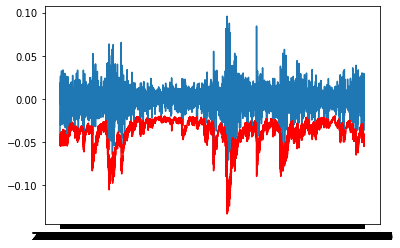

In [655]:
plt.plot(Log_Returns_train.index, Log_Returns_train)
plt.plot(VaR_dyn_99, color = "red")

### Backtesting de la VaR dynamique

Une fois de plus, la VaR dynamique est soumis à validation par un Backtesting sur l'échantillon test.

Rappelons que les variables de dépassements sont les rendements en $t+1$ qui sont inférieurs à la VaR calculée en $t$ : $I_t = \mathbb{1}_{r_{t+1} < VaR_{h,t+1}(\alpha)} \sim \mathcal{B}(1-\alpha)$. 

Et donc que leur somme suit une loi Binomiale de paramètre $n$ et $1- \alpha$ : $\sum_{t=0}^{n} I_t \sim \mathcal{B}(n,1-\alpha)$.

Cette formule prend tout son sens puisque la VaR dynamique varie chaque jour.

Ainsi, la fonction de Backtesting est réimplémentée comme suit :

In [651]:
# Construction de l'échantillon des exceptions
def Backtesting_dyn(data, VaR):
    n = len(data)
    exception_nb = 0 
    for i in range(n):
        if data[i] < VaR[i]:
            exception_nb +=1
    return exception_nb

Il convient comme convenu de tester si la proportion empirique d'exceptions est bien égal à $1-\alpha$. Pour un niveau de $\alpha = 99\%$, la VaR dynamique peut donc être backtesté comme suit :

In [654]:
# Application de la fonction pour la VaR GEV
backesting_dyn_99 = Backtesting_dyn(Log_Returns_test, VaR_dyn_99)
n = len(Log_Returns_test)

# Calcul de la proportion d'exceptions
prop_dyn = backesting_dyn_99/n
print("La proportion d'exceptions est égale à %.3f" % prop_dyn)

# Test d'adéquation
p_value = sps.binom_test(x = backesting_dyn_99, n = n, p=0.01)
print('p-value=%.3f' % p_value)
# Interprétation
alpha = 0.05
if p_value > alpha:
    print("Le nombre d'exceptions au regard de la VaR dynamique 99% suit bien une Binomiale avec p = 1%")
else:
    print("Le nombre d'exceptions au regard de la VaR dynamique 99% ne suit pas une Binomiale avec p = 1%")

La proportion d'exceptions est égale à 0.001
p-value=0.001
Le nombre d'exceptions au regard de la VaR dynamique 99% ne suit pas une Binomiale avec p = 1%


Malheureusement, la VaR dynamique reste trop conservatrice au regard de sa proportion très faible d'exception, et ne peut donc être validé par le Backtesting.